In [4]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.preprocessing import Imputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

In [5]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data = store['data']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 174551 entries, (A, 2011-02-28 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 62 columns):
returns                  174551 non-null float64
t-1                      174551 non-null float64
t-2                      174551 non-null float64
t-3                      174551 non-null float64
t-4                      174551 non-null float64
t-5                      174551 non-null float64
t-6                      174551 non-null float64
t-7                      174551 non-null float64
t-8                      174551 non-null float64
t-9                      174551 non-null float64
t-10                     174551 non-null float64
t-11                     174551 non-null float64
t-12                     174551 non-null float64
year_2010                174551 non-null uint8
year_2011                174551 non-null uint8
year_2012                174551 non-null uint8
year_2013                174551 non-null uint8
year_2014           

### Stock Prices

In [7]:
y = data.returns
X = data.drop('returns', axis=1)

### Binary Outcome

In [8]:
y_binary = (y>0).astype(int)

### 2 Lags Only

In [9]:
X2 = X.loc[:, ['t-1', 't-2']]
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 174551 entries, (A, 2011-02-28 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 2 columns):
t-1    174551 non-null float64
t-2    174551 non-null float64
dtypes: float64(2)
memory usage: 3.2+ MB


## Explore Data

In [10]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    174551.000000
mean          0.009913
std           0.055606
min          -0.128560
10%          -0.064080
20%          -0.036451
30.0%        -0.017798
40%          -0.002855
50%           0.010522
60%           0.023904
70%           0.038457
80%           0.056050
90%           0.082772
max           0.146335
Name: returns, dtype: float64

## Custom KFold

In [11]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""
    def __init__(self, n_splits=3):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        dates = np.sort(X.index.get_level_values('date').unique())[::-1]
        X['idx'] = range(len(X))
        for date in dates[:self.n_splits]:
            train_idx = X.loc[X.index.get_level_values('date') < date, 'idx'].values
            test_idx = X.loc[X.index.get_level_values( 'date') == date, 'idx'].values
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [12]:
def regression_benchmark():
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

In [13]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Simple Regression Tree

### Configure Tree

In [112]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=4,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    presort=False)

### Train Decision Tree

In [15]:
%%timeit
reg_tree_t2.fit(X=X2, y=y)

129 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
reg_tree_t2.fit(X=X2, y=y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

### Visualize Tree

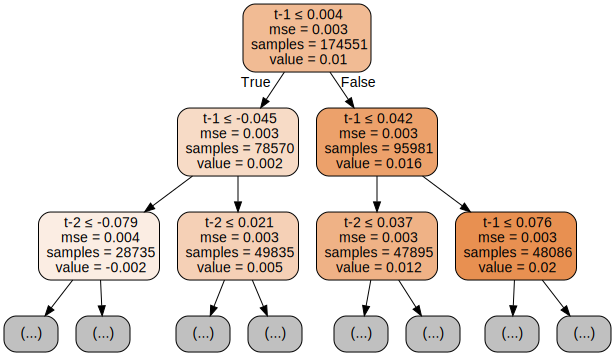

In [116]:
out_file = 'figures/reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file,
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Linear Regression

#### statsmodels OLS

In [19]:
%%timeit
ols_model = sm.OLS(endog=y_binary, exog=sm.add_constant(X2)).fit()

17.6 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
ols_model = sm.OLS(endog=y, exog=sm.add_constant(X2)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1904.
Date:                Mon, 01 Oct 2018   Prob (F-statistic):               0.00
Time:                        16:00:15   Log-Likelihood:             2.5857e+05
No. Observations:              174551   AIC:                        -5.171e+05
Df Residuals:                  174548   BIC:                        -5.171e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.000     65.281      0.0

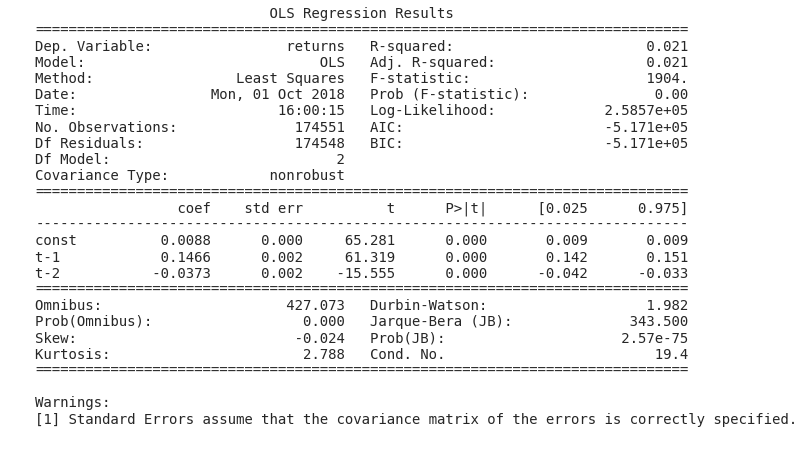

In [21]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(ols_model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('/home/stefan/Dropbox/Data Science/AI & ML/Algorithmic Trading/09 Decision Trees & Random Forests/Figures/ols_summary.png', bbox_inches='tight', dpi=300);

#### statsmodels AR(2) Model

Coefficients slighty different because AR model treats returns as a single time series instead creating groups by ticker.

In [22]:
%%timeit
sm.tsa.ARMA(endog=y, order=(2,0)).fit()

950 ms ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
ar_model = sm.tsa.ARMA(endog=y, order=(2,0)).fit()

In [24]:
pd.DataFrame({'AR(2)': ar_model.params.values, 
              'OLS': ols_model.params.values}, 
             index=ols_model.params.index)

,AR(2),OLS
const,0.009913,0.008849
t-1,0.150610,0.146645
t-2,-0.023615,-0.037274


In [25]:
ar_preds = ar_model.predict()

#### ARMA(2,2)

In [26]:
%%timeit
sm.tsa.ARMA(endog=y, order=(2, 2)).fit()

2min 34s ± 4.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
arma_model = sm.tsa.ARMA(endog=y, order=(2, 2)).fit()
print(arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:               174551
Model:                     ARMA(2, 2)   Log Likelihood              258796.209
Method:                       css-mle   S.D. of innovations              0.055
Date:                Mon, 01 Oct 2018   AIC                        -517580.417
Time:                        16:23:38   BIC                        -517519.997
Sample:                             0   HQIC                       -517562.529
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0099      0.000     58.085      0.000       0.010       0.010
ar.L1.returns     0.6295      0.030     21.000      0.000       0.571       0.688
ar.L2.returns     0.2045      0.017     

In [28]:
arma_preds = arma_model.predict()

In [29]:
preds = X2.assign(arma=arma_preds, ar=ar_preds).sample(frac=.1).sort_values(['t-1', 't-2'])
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17455 entries, (UEC, 2016-11-30 00:00:00) to (TOWR, 2013-08-31 00:00:00)
Data columns (total 4 columns):
t-1     17455 non-null float64
t-2     17455 non-null float64
arma    17455 non-null float64
ar      17455 non-null float64
dtypes: float64(4)
memory usage: 616.1+ KB


In [32]:
q = 20
preds['t-1q'] = pd.qcut(preds['t-1'], q=q, labels=list(range(1, q+1))).astype(int)
preds['t-2q'] = pd.qcut(preds['t-2'], q=q, labels=list(range(1, q+1))).astype(int)

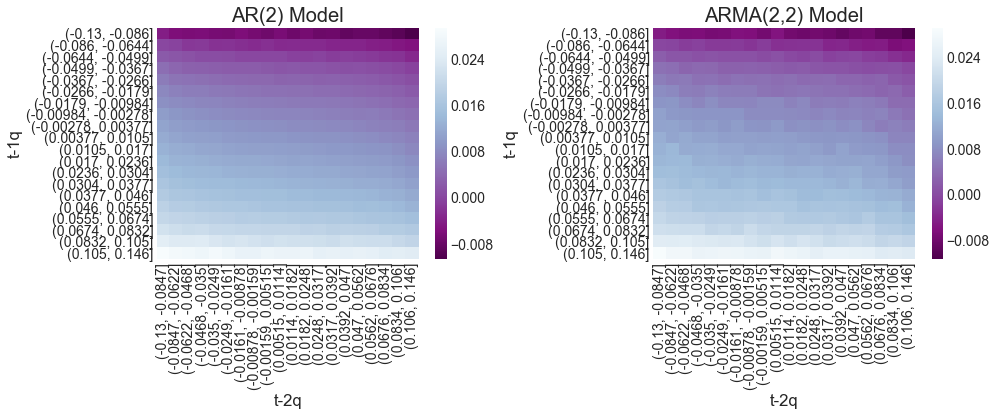

In [33]:
q = 20
preds['t-1q'] = pd.qcut(preds['t-1'], q=q)
preds['t-2q'] = pd.qcut(preds['t-2'], q=q)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.heatmap(preds.groupby(['t-1q', 't-2q']).ar.median().unstack(), ax=axes[0], cmap='BuPu_r')
axes[0].set_title('AR(2) Model')
sns.heatmap(preds.groupby(['t-1q', 't-2q']).arma.median().unstack(), ax=axes[1], cmap='BuPu_r')
axes[1].set_title('ARMA(2,2) Model')
fig.tight_layout();

### sklearn Linear Regression

In [34]:
lin_reg = LinearRegression()

In [35]:
%%timeit
lin_reg.fit(X=X2,y=y)

9.94 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
lin_reg.intercept_

0.008849391302235901

In [37]:
lin_reg.coef_

array([ 0.14664542, -0.03727445])

### Plot Decision Surfaces

In [38]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].min(), X2['t-1'].max(), 1000),
                     np.linspace(X2['t-2'].min(), X2['t-2'].max(), 1000))
X_data = np.c_[t1.ravel(), t2.ravel()]

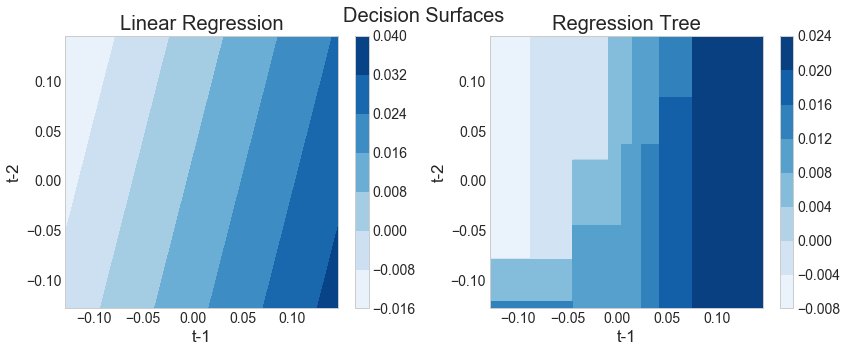

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = regression_tree.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Simple Classification Tree

### Loss Functions

In [40]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

In [41]:
def gini(f):
    return 2*f*(1-f)

In [42]:
def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

In [43]:
from sklearn.metrics import accuracy_score

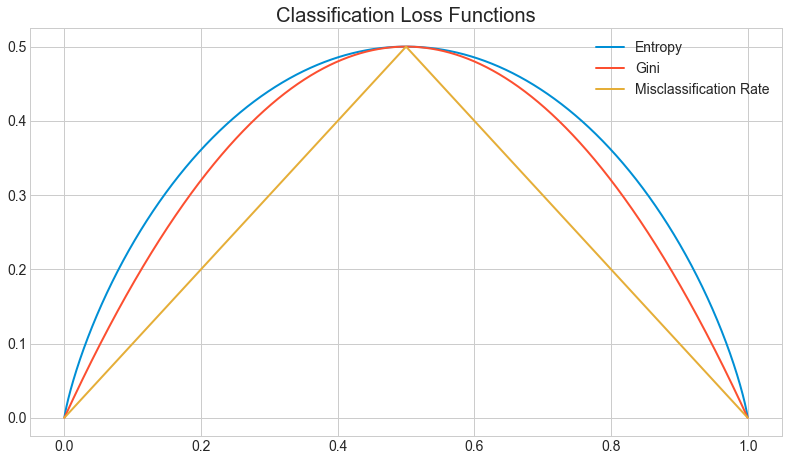

In [44]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2));

#### Compare computation time

In [45]:
%%timeit
misclassification_rate(x)

13.9 µs ± 91.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
%%timeit
gini(x)

11 µs ± 40.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [47]:
%%timeit
entropy(x)

193 µs ± 461 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Configure Tree

In [117]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=4,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None,
                                     presort=False)

### Train Tree

In [49]:
%%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

145 ms ± 540 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [118]:
clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

### Visualize Tree

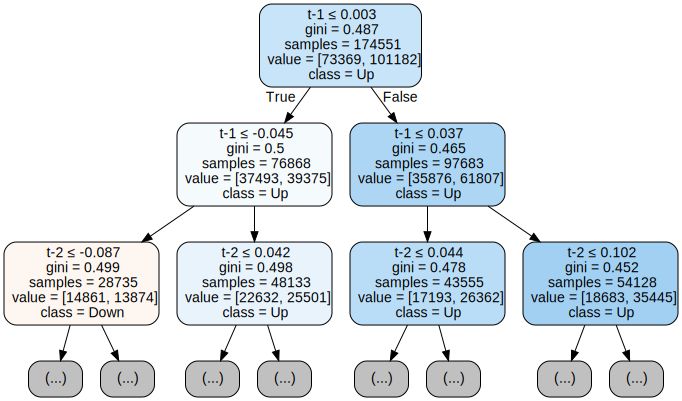

In [126]:
out_file = 'figures/clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file,
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Logistic Regression

#### Statsmodels

In [52]:
%%timeit
sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit(disp=0)

101 ms ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
model = sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.671948
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:               174551
Model:                          Logit   Df Residuals:                   174548
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Oct 2018   Pseudo R-squ.:                 0.01242
Time:                        18:22:35   Log-Likelihood:            -1.1729e+05
converged:                       True   LL-Null:                   -1.1876e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2905      0.005     57.954      0.000       0.281       0.300
t-1            4.8250      0.

#### sklearn

In [54]:
logistic_reg = LogisticRegression()

In [55]:
%%timeit
logistic_reg.fit(X=X2, y=y_binary)

148 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
logistic_reg.coef_

array([[ 4.78476114, -1.07214076]])

### Plot Decision Surfaces

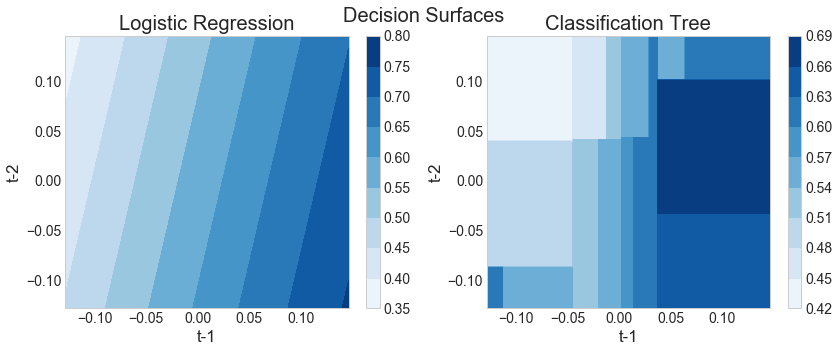

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = logistic_reg.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = classifier.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Print Decision Path

Inspired by https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [58]:
from sklearn.tree._tree import Tree
help(Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The maximal depth of the tree.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leaves,

In [59]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [60]:
tree_to_code(classifier, X2.columns)

def tree(t-1, t-2):
   if t-1 <= 0.27%
     if t-1 <= -4.47%
       if t-2 <= -8.69%
         if t-1 <= -11.27%
           return 61.89%
         else:  # if t-1 > -11.27%
           return 54.09%
       else:  # if t-2 > -8.69%
         if t-2 <= 4.03%
           return 48.57%
         else:  # if t-2 > 4.03%
           return 44.83%
     else:  # if t-1 > -4.47%
       if t-2 <= 4.19%
         if t-1 <= -2.01%
           return 52.80%
         else:  # if t-1 > -2.01%
           return 55.72%
       else:  # if t-2 > 4.19%
         if t-1 <= -1.20%
           return 46.69%
         else:  # if t-1 > -1.20%
           return 51.19%
   else:  # if t-1 > 0.27%
     if t-1 <= 3.69%
       if t-2 <= 4.39%
         if t-1 <= 1.44%
           return 59.90%
         else:  # if t-1 > 1.44%
           return 62.52%
       else:  # if t-2 > 4.39%
         if t-1 <= 2.91%
           return 56.80%
         else:  # if t-1 > 2.91%
           return 60.95%
     else:  # if t-1 > 3.69%
       if t-

## Classification Tree with all Features

### Train-Test Split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [122]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [123]:
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [124]:
y_score = clf.predict_proba(X=X_test)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_test)

0.6096254056858367

### Plot Tree

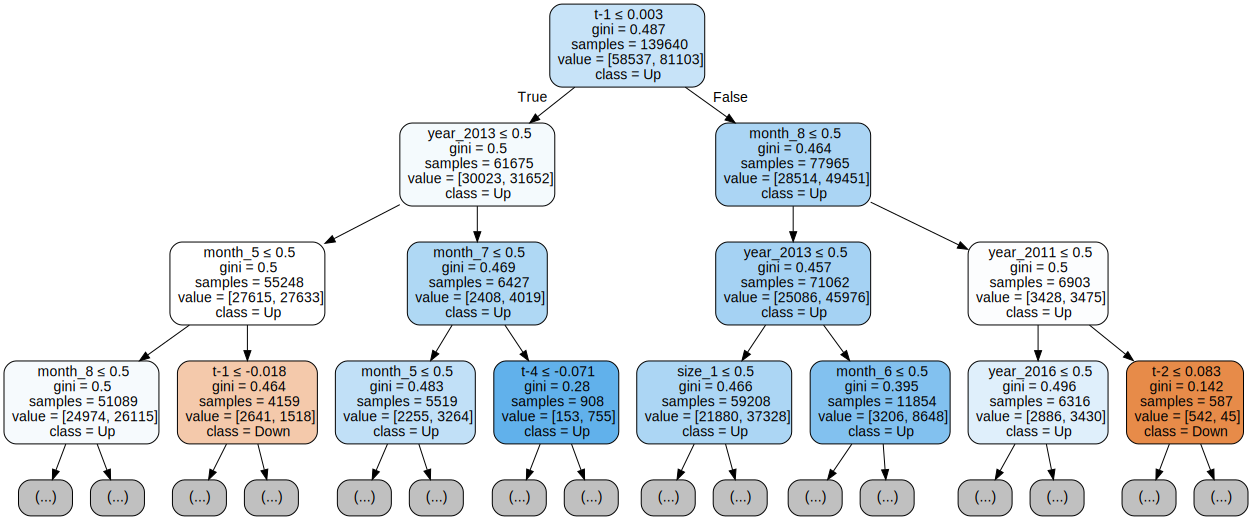

In [125]:
out_file = 'figures/clf_tree.dot'
dot_data = export_graphviz(clf,
                           out_file=out_file,
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [67]:
y_pred = classifier.predict_proba(X_test)[:, 1]

In [68]:
roc_auc_score(y_true=y_test, y_score=y_pred)

0.6096254056858367

## Regression Tree with all Features

### Train-Test Split

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Configure Tree

In [129]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        presort=False)

### Train Model

In [130]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

### Visualize Tree

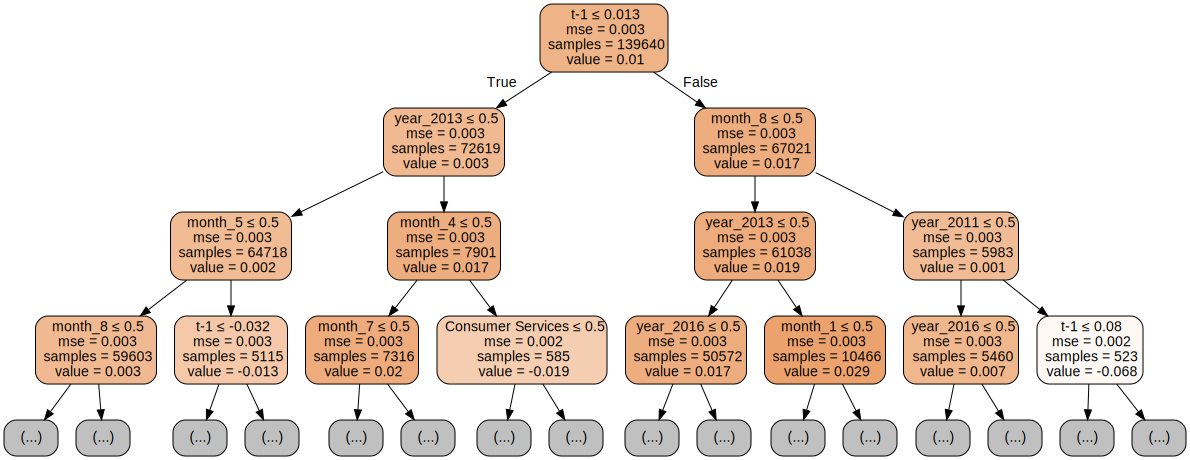

In [131]:
out_file = 'figures/reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file,
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [73]:
y_pred = regression_tree.predict(X_test)

In [74]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.05405046249923117

## Parameter Tuning

Cross-validate key parameters

In [75]:
def plot_cv_results(cv_scores, metric='AUC', parameter='Max. Depth'):
    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(cv_scores)
    sns.tsplot(df.values, time=df.columns, ax=ax, lw=2)
    ax.set_title(f'{len(df)}-Fold Cross-Validation Result')
    ax.set_xlabel(parameter)
    ax.set_ylabel(metric)
    if metric == 'AUC':
        ax.axvline(df.mean().idxmax(), ls='--', c='k', lw=1);
        ax.axhline(classification_benchmark(), c='red', lw=1, ls='--') 
    else:
        ax.axvline(df.mean().idxmin(), ls='--', c='k', lw=1);
        ax.axhline(regression_benchmark(), c='red', lw=1, ls='--')

### Classifier

### Cross-Validation Score

In [76]:
cv = OneStepTimeSeriesSplit(n_splits=10)

In [77]:
clf_results = {}
for max_depth in range(1, 26):
    clf_tree = DecisionTreeClassifier(criterion='gini',
                                      max_depth=max_depth,
                                      min_samples_leaf=5,
                                      random_state=42)
    clf_results[max_depth] = cross_val_score(clf_tree,
                                             X=X,
                                             y=y_binary,
                                             scoring='roc_auc',
                                             n_jobs=-1,
                                             cv=cv)

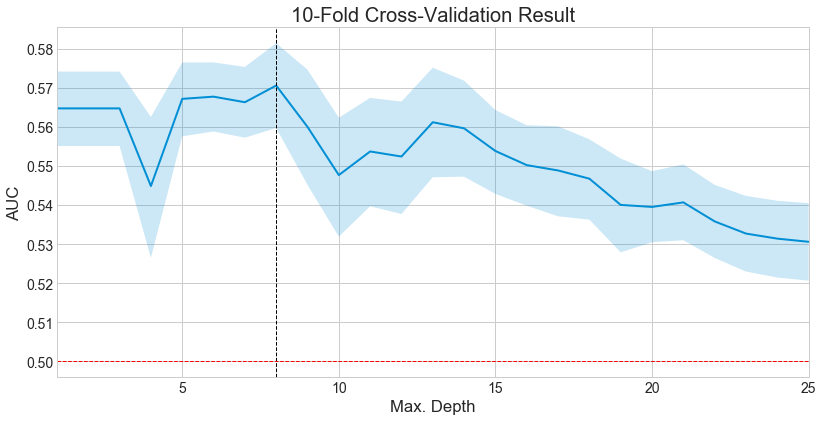

In [78]:
plot_cv_results(clf_results)

### Train-Test Result

In [79]:
max_depths = range(1, 26)

In [80]:
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves

In [81]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=max_depth,
                                 min_samples_leaf=500,
                                 max_features='auto',
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)    
        leaves[max_depth].append(get_leaves_count(clf))
        
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

## Regression Tree

### Cross-Validation Scores

In [82]:
reg_results = {}
for max_depth in range(1, 26):
    reg_tree = DecisionTreeRegressor(criterion='mse',
                                     max_depth=max_depth,
                                     min_samples_leaf=500,
                                     random_state=42)
    reg_results[max_depth] = np.sqrt(-cross_val_score(reg_tree,
                                             X=X,
                                             y=y,
                                             scoring='neg_mean_squared_error',
                                             n_jobs=-1,
                                             cv=cv))

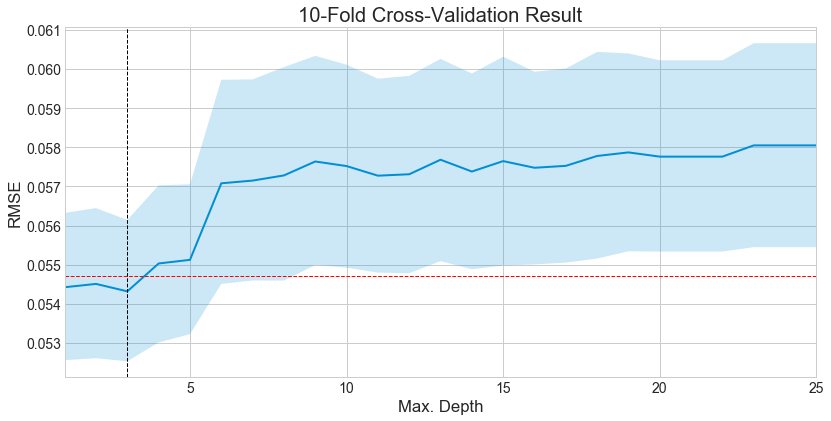

In [83]:
plot_cv_results(reg_results, metric='RMSE')

In [84]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=500,
                                     max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = np.sqrt(mean_squared_error(
            y_pred=train_pred, y_true=y_train))
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = np.sqrt(mean_squared_error(
            y_pred=test_pred, y_true=y_test))
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

#### Plot Results

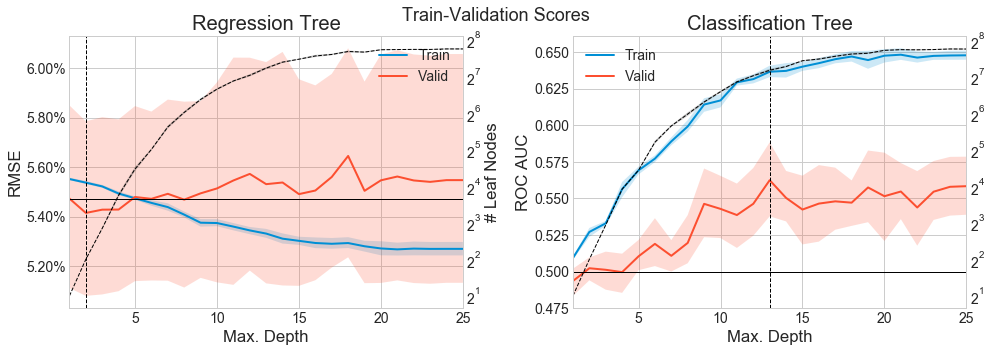

In [85]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
time = pd.Series(max_depths, name='Max. Depth')
sns.tsplot(data=np.dstack((reg_train_scores, reg_valid_scores)),
           time=time,
           condition=['Train', 'Valid'],
           ci=95,
           ax=axes[0],
           lw=2)
ax0 = axes[0].twinx()
sns.tsplot(data=reg_leaves.values, time=time, ax=ax0, ls='--', lw=1, color='k')
ax0.set_yscale('log', basey=2)
ax0.grid(None)
ax0.set_ylabel('# Leaf Nodes')
axes[0].set_title('Regression Tree')
axes[0].set_ylabel('RMSE')
axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[0].axvline(x=reg_valid_scores.mean().idxmin(), ls='--', c='k', lw=1)
axes[0].axhline(y=regression_benchmark(), ls='-', c='k', lw=1)


sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)),
           time=pd.Series(max_depths, name='Max. Depth'),
           condition=['Train', 'Valid'],
           ci=95,
           ax=axes[1],
           lw=2)
ax1 = axes[1].twinx()
sns.tsplot(data=clf_leaves.values, time=time, ax=ax1, ls='--', lw=1, color='k')
ax1.set_yscale('log', basey=2)
ax1.grid(None)
axes[1].set_title('Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=classification_benchmark(), ls='-', c='k', lw=1)

fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)

### GridSearch

#### Classification Tree

In [87]:
OneStepTimeSeriesSplit

__main__.OneStepTimeSeriesSplit

In [88]:
clf = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': range(10, 20),
              'min_samples_leaf': [250, 500, 750],
              'max_features': ['sqrt', 'auto']
              }

In [89]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True)

In [90]:
gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=<__main__.OneStepTimeSeriesSplit object at 0x7f4c9c40dc88>,
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 20), 'min_samples_leaf': [250, 500, 750], 'max_features': ['sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [91]:
gridsearch_clf.best_params_

{'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 250}

In [92]:
gridsearch_clf.best_score_

0.5671858420929381

#### Regression Tree

In [93]:
reg_tree = DecisionTreeRegressor(random_state=42)

param_grid = {'max_depth': [1,2],
              'min_samples_leaf': [10],
              'max_features': [None, 'sqrt']
              }

In [94]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [95]:
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=<__main__.OneStepTimeSeriesSplit object at 0x7f4c9c40dc88>,
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2], 'min_samples_leaf': [10], 'max_features': [None, 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [96]:
gridsearch_reg.best_params_

{'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 10}

In [97]:
np.sqrt(-gridsearch_reg.best_score_)

0.05430745233309579

In [98]:
regression_benchmark()

0.05471274923536803

### Learning Curves

#### Classifier

In [99]:
sizes = np.arange(.1, 1.01, .1)

In [100]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                          X,
                                                          y_binary,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='roc_auc',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
clf_data = np.dstack((train_scores.T, valid_scores.T))

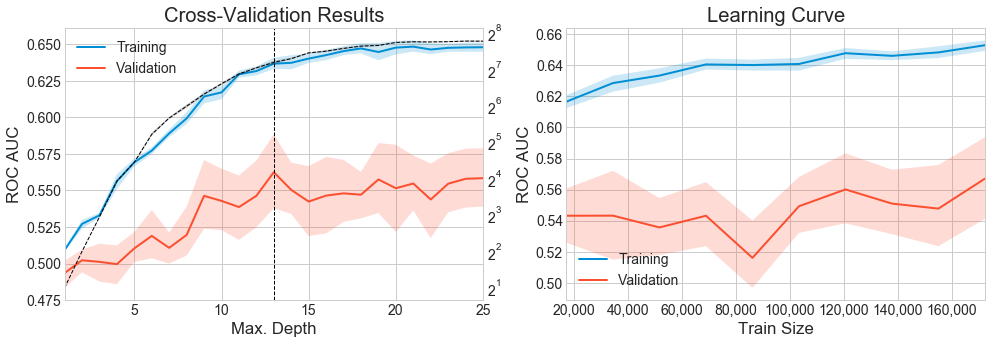

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
condition = ['Training', 'Validation']
sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)),
           time=pd.Series(max_depths, name='Max. Depth'),
           condition=condition,
           ci=95,
           ax=axes[0],
           lw=2)
ax1 = axes[0].twinx()
sns.tsplot(data=clf_leaves.values, time=time, ax=ax1, ls='--', lw=1, color='k')
ax1.set_yscale('log', basey=2)
ax1.grid(None)
axes[0].set_title('Cross-Validation Results')
axes[0].set_ylabel('ROC AUC')
axes[0].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)


sns.tsplot(data=clf_data, 
           time=pd.Series(train_sizes, name='Train Size'), 
           condition=condition, 
           ci=95, 
           ax=axes[1],
          lw=2)
axes[1].set_title('Learning Curve')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))


# fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
# fig.subplots_adjust(top=.9)

#### Regression Tree

In [102]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                          X, y,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='neg_mean_squared_error',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
reg_data = np.dstack((train_scores.T, valid_scores.T))

#### Plot Result

In [103]:
time = pd.Series(train_sizes, name='Train Size')

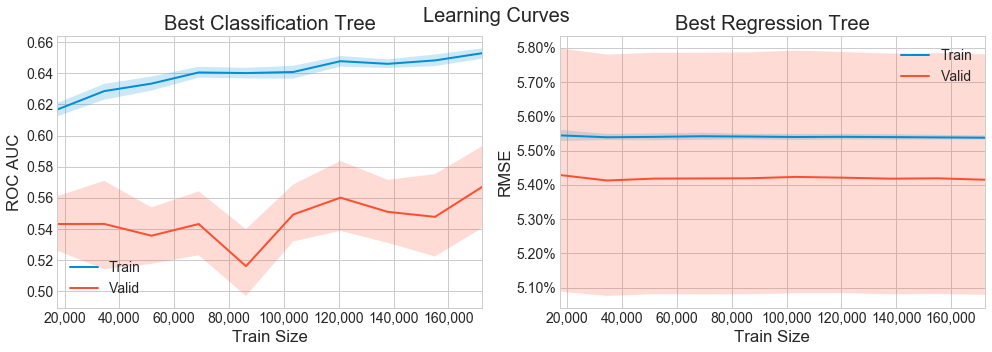

In [104]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.tsplot(data=clf_data, 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[0],
          lw=2)
axes[0].set_title('Best Classification Tree')
axes[0].set_ylabel('ROC AUC')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.tsplot(data=np.sqrt(-reg_data), 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[1],
           lw=2)
axes[1].set_title('Best Regression Tree')
axes[1].set_ylabel('RMSE')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
fig.suptitle('Learning Curves', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Feature Importance

In [105]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

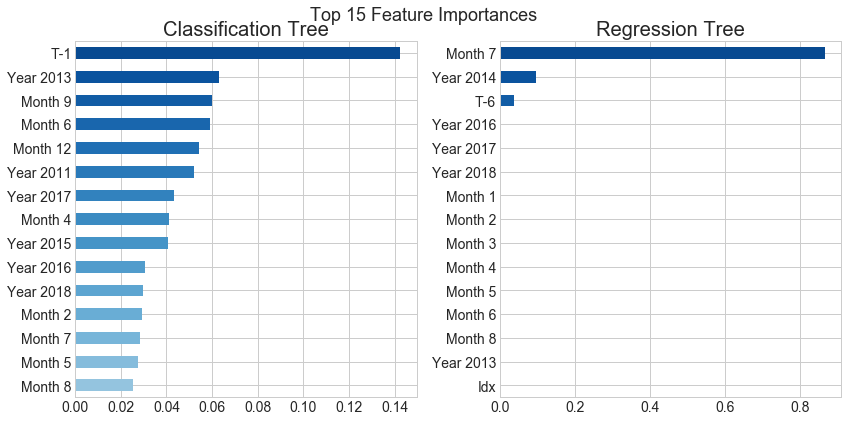

In [106]:
fig, axes= plt.subplots(ncols=2, figsize=(12,6))
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[0], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[1], title='Regression Tree', color=color)
fig.suptitle(f'Top {top_n} Feature Importances', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9);

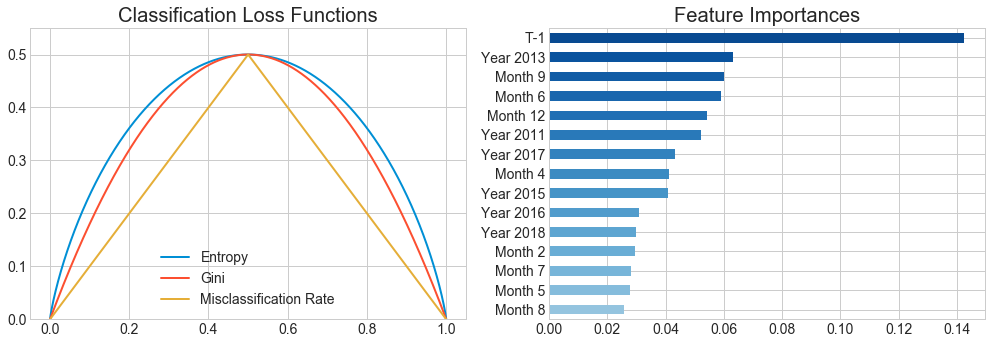

In [107]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, ax=axes[0], ylim=(0, .55)))

top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Feature Importances', color=color)


# fig.suptitle('Best Classification Tree', fontsize=20)
fig.tight_layout()
# fig.subplots_adjust(top=.9);

In [108]:
dt = pd.DataFrame({'y': [1,2,3], 'x': [2, np.nan, 3]})
dt

,x,y
0,2.0,1
1,NaN,2
2,3.0,3
